In [297]:
import os
import datetime
import copy
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import Tracab as tracab
import Tracking_Visuals as vis
import Tracking_Velocities as vel
import helpers

import importlib
importlib.reload(tracab)
importlib.reload(helpers)
importlib.reload(vis)

<module 'Tracking_Visuals' from '/Users/jeffbalkanski/research_soccer/SoccerTrackingData3/Tracking_Visuals.py'>

In [2]:
# config
current_dir = os.path.dirname(os.getcwd())
dir_path = os.path.join(current_dir, 'Aalborg_Jeff') # path to directory of Tracab data
LEAGUE = 'DSL'

# Read data

In [3]:
# config
fname = '984455'
match_id = fname

# # example
# player = team0_players[14]

In [4]:
# read
fpath = os.path.join(dir_path, fname, fname + '_TracDAT')
print(fpath)
frames_tb, match_tb, team1_players, team0_players = tracab.read_tracab_match_data(LEAGUE, fpath, fname, verbose=True)

/Users/jeffbalkanski/research_soccer/Aalborg_Jeff/984455/984455_TracDAT
Reading match metadata
Reading match tracking data
Timestamping frames
Measuring velocities
home goalkeeper(s):  [28]
away goalkeeper(s):  [1]
0 70642
70643 142733


# Positions

In [80]:
# positions
player_id_to_name = pd.read_csv('../playerid_jerseynum_map.csv')
player_id_to_name = player_id_to_name[player_id_to_name['Match ID'] == int(match_id)]

In [82]:
player_id_to_name['Starting Position'].unique()

array(['GK', 'LFB', 'RFB', 'CD', 'CM', 'LM', 'RM', 'FW', 'Sub', 'AM',
       'RWB', 'LWB', 'DM', 'CDM', 'LCM', 'RCM', 'LAM', 'CAM', 'RAM',
       'ACM'], dtype=object)

In [230]:
# map player id and jersey num
def map_playerids_positions(team1_players, team0_players, match_id, loc_mapping='../playerid_jerseynum_map.csv'):
    mapping = pd.read_csv(loc_mapping)
    player_id_to_name = mapping[mapping['Match ID'] == int(match_id)]
    all_players_pre = [(x[0], x[1], 1) for x in team1_players.items()] + [(x[0], x[1], 0) for x in team0_players.items()]
    all_players = []
    for num, player, team in all_players_pre:
        team_str = 'Home' if team else 'Away'
        player_id = None
        players_team = player_id_to_name[player_id_to_name['Team'] == team_str]
        player_id, starting_pos = players_team[players_team['Jersey Num'] == num][['Playerid', 'Starting Position']].values[0]
        all_players.append([player_id, team, num, starting_pos, player])
        
    # get rid of non starters
    all_players = pd.DataFrame(all_players, columns=['player_id', 'Team', 'jersey_num', 'start_pos', 'obj'])
    all_players = all_players[all_players['start_pos'] != 'Sub']

    return all_players

# get mapping
all_players = map_playerids_positions(team1_players, team0_players, match_id)

## Add main positions -> F, M, D

In [336]:
# main positions for averages
main_positions = {
    'F': ['FW'],
    'M': ['CM', 'LM', 'RM', 'DM', 'CDM', 'LCM', 'RCM', 'AM', 'ACM', 'LAM', 'CAM', 'RAM'],
    'D': ['CD', 'RWB', 'LWB', 'RFB', 'LFB'],
    'GK': ['GK'],
    'Sub': ['Sub']
}

main_positions_inv = {}
for k, positions in main_positions.items():
    for pos in positions:
        main_positions_inv[pos] = k

all_players['start_pos_super'] = all_players['start_pos'].apply(lambda x: main_positions_inv[x])

# Players, time on the field, find subs

In [337]:
# count frames for players
players_in_frames = defaultdict(int)
for f in frames_tb:
    for num in f.team1_jersey_nums_in_frame:
        players_in_frames[(1, num)] += 1
    for num in f.team0_jersey_nums_in_frame:
        players_in_frames[(0, num)] += 1

In [338]:
# find who is on the field
player_times = []
for (team, num), n_frames in players_in_frames.items():
    player_times.append([team, num, n_frames/25/60])
    
player_time_df = pd.DataFrame(player_times, columns=['Team', 'jersey_num', 'time_played'])

# merge back with player data
all_players_w_time = pd.merge(player_time_df, all_players, on=['Team', 'jersey_num'])

### filter out players who do not play full game

In [339]:
players_full_game = all_players_w_time[all_players_w_time['time_played'] > 90]

In [340]:
players_full_game.groupby('start_pos').count()['player_id']

start_pos
CD     4
CM     2
FW     3
GK     2
LFB    2
LM     1
RFB    2
RM     1
Name: player_id, dtype: int64

# Add Energy Expenditure

In [367]:
import Tracking_Fatigue as fatigue
importlib.reload(fatigue)

# add energy expenditure
helpers.add_metric_to_player(team1_players, team0_players, fatigue.get_energy_expenditure, 'energy_x', skip_end=1)

Done with player 2 of team 1
Done with player 3 of team 1
Done with player 5 of team 1
Done with player 6 of team 1
Done with player 8 of team 1
Done with player 10 of team 1
Done with player 11 of team 1
Done with player 12 of team 1
Done with player 15 of team 1
Done with player 18 of team 1
Done with player 27 of team 1
Done with player 28 of team 1
Done with player 30 of team 1
Done with player 1 of team 0
Done with player 3 of team 0
Done with player 4 of team 0
Done with player 5 of team 0
Done with player 6 of team 0
Done with player 8 of team 0
Done with player 9 of team 0
Done with player 14 of team 0
Done with player 16 of team 0
Done with player 17 of team 0
Done with player 18 of team 0
Done with player 21 of team 0
Done with player 27 of team 0
Done with player 30 of team 0


In [368]:
player = all_players['obj'].iloc[4]

In [369]:
player

In [373]:
# get series
EX = helpers.get_all_values(team1_players[2], 'energy_x', start=1, skip_last=1)

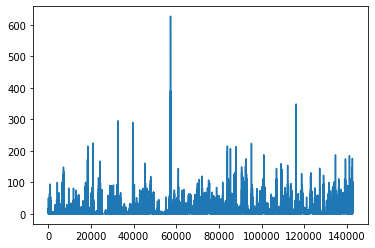

In [375]:
plt.plot(EX)

# Get Energy expenditure Per position
> `EX_all`

In [384]:
# for row in players_full_game.to_dict(orient='records'):
#     print(row)

In [378]:
# example
EX_1_10 = fatigue.get_energy_expenditure(team1_players[10])
plt.plot(np.cumsum(EX_1_10))

In [381]:
# get all values
metric_values = []
for row in players_full_game.to_dict(orient='records'):
    player = row['obj']
    print(player, row['Team'], row['jersey_num'])
    val_array = fatigue.get_energy_expenditure(player)
    metric_values.append([row['Team'], row['jersey_num'], row['start_pos'], row['start_pos_super'], val_array])
    
EX_all = np.array(metric_values)

<Tracab.tracab_player object at 0x1c17d68150> 1 27
<Tracab.tracab_player object at 0x1c17d68410> 1 30
<Tracab.tracab_player object at 0x1c17d68050> 1 10
<Tracab.tracab_player object at 0x1c17d36bd0> 1 5
<Tracab.tracab_player object at 0x1c69bad750> 1 3
<Tracab.tracab_player object at 0x1c17d68090> 1 8
<Tracab.tracab_player object at 0x1c17d68550> 1 28
<Tracab.tracab_player object at 0x1b17b2eb50> 1 2
<Tracab.tracab_player object at 0x1c17d68210> 1 18
<Tracab.tracab_player object at 0x1c17d68290> 0 3
<Tracab.tracab_player object at 0x1c17d685d0> 0 17
<Tracab.tracab_player object at 0x1c17d68450> 0 16
<Tracab.tracab_player object at 0x1c17d68110> 0 6
<Tracab.tracab_player object at 0x1c17d68350> 0 1
<Tracab.tracab_player object at 0x1c17d683d0> 0 4
<Tracab.tracab_player object at 0x1c17d68610> 0 9
<Tracab.tracab_player object at 0x1c17d68310> 0 5


In [388]:
# all cumulative
cumul_EX_per_pos = [(x[:3], np.cumsum(x[4])) for x in metric_values]

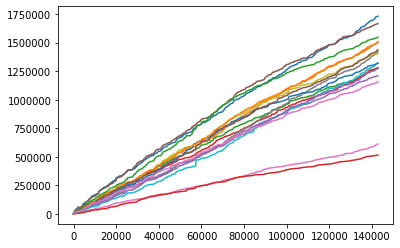

In [389]:
# plot all
for pos, vals in cumul_EX_per_pos:
    plt.plot(vals)
    plt.plot()

# Get energy expenditure per position

## Total energy expanded per player

In [412]:
total_energy_per_player = list(map(lambda row: [row[0], row[1], row[3], sum(row[4])], EX_all))

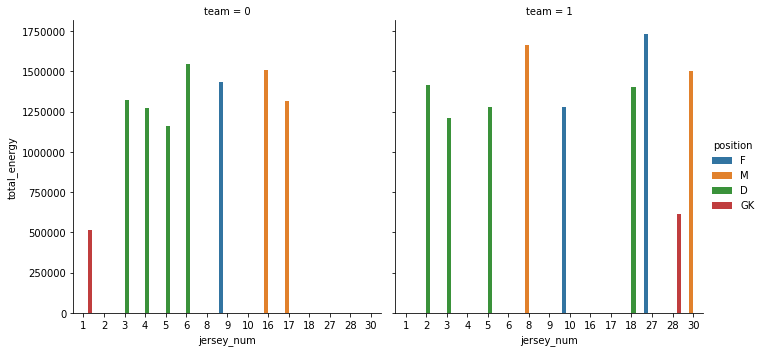

In [435]:
sns.catplot(
    data=pd.DataFrame(data=total_energy_per_player, columns=['team', 'jersey_num', 'position', 'total_energy']),
    x='jersey_num', y='total_energy', hue='position',
    col='team', kind='bar', height=5,
)

plt.show('Bar plot of t')
plt.show()

## Total energy expanded per position

In [448]:
EX_all[0]

array([1, 27, 'FW', 'F',
       array([7.56299997, 7.07788846, 6.9129645 , ..., 3.67626652, 2.97328458,
       2.40943142])], dtype=object)

In [482]:
total_E_per_pos = []
for position in ['F', 'M', 'D', 'GK']:
    total_for_pos = [(pos, np.sum(vals)) for (team, num, _, pos, vals) in EX_all if pos == position]
    total_E_per_pos.append((position, np.mean([x for _, x in total_for_pos])))

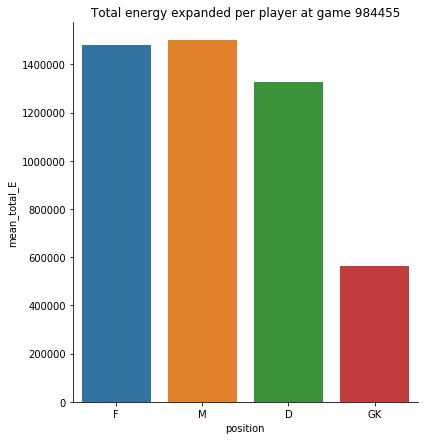

In [496]:
data_total_E = pd.DataFrame(total_E_per_pos, columns=['position', 'mean_total_E'])
sns.catplot(x='position', y='mean_total_E', data=data_total_E, kind='bar', height=6)
plt.title('Total energy expanded per player at game {}'.format(match_id))
plt.show()

## Mean energy expanded per position

In [502]:
EX_all[0]

array([1, 27, 'FW', 'F',
       array([7.56299997, 7.07788846, 6.9129645 , ..., 3.67626652, 2.97328458,
       2.40943142])], dtype=object)

In [511]:
mean_E_per_pos = []
for position in ['F', 'D', 'M', 'GK']:
    mean_for_pos = np.array([(row[3], row[4]) for row in EX_all if row[3] == position])
    mean_pos = np.mean([player[1] for player in mean_for_pos], axis=0)
    mean_E_per_pos.append([position, np.cumsum(mean_pos)])

/Users/jeffbalkanski/anaconda3/envs/soccer3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  


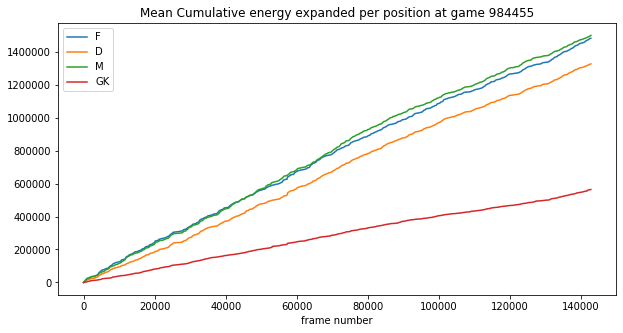

In [515]:
fig, ax = plt.subplots(figsize=(10, 5))
for pos, vals in mean_E_per_pos:
    ax.plot(vals, label=pos)
    
plt.title('Mean Cumulative energy expanded per position at game {}'.format(match_id))
plt.legend()
plt.xlabel('frame number')
plt.savefig('./figures/cumul_E_per_pos_game_{}'.format(match_id))
plt.show()

# Derivative of energy expanded
## Linear fit and difference

In [572]:
mean_E_per_pos

[['F', array([9.78779658e+00, 1.79879220e+01, 2.47082646e+01, ...,
         1.48136034e+06, 1.48136326e+06, 1.48136624e+06])],
 ['D', array([9.77836996e-01, 1.70402214e+00, 2.22820415e+00, ...,
         1.32657809e+06, 1.32658165e+06, 1.32658520e+06])],
 ['M', array([1.90138056e+00, 3.82884505e+00, 5.83814874e+00, ...,
         1.49923022e+06, 1.49924624e+06, 1.49926697e+06])],
 ['GK', array([1.83127742e+00, 3.63576645e+00, 5.42064128e+00, ...,
         5.63841413e+05, 5.63847534e+05, 5.63853607e+05])]]

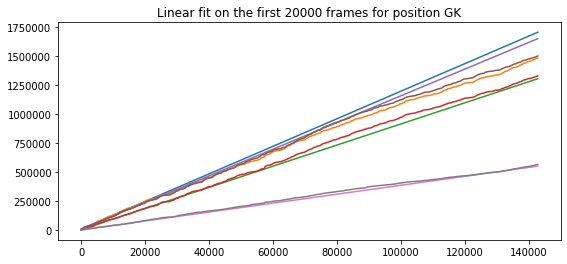

In [703]:
first_k = 20000
linear = {'ratio': [], 'error': []}
ax = plt.subplots(figsize=(9, 4))
for pos, series in mean_E_per_pos:
    series_small = series[:first_k]
    xs_small, xs = np.array(range(len(series_small))), np.array(range(len(series)))
    slope, intercept = np.polyfit(xs_small, series_small, 1)

    # error
    linear_extended = xs*slope + intercept
    linear['error'].append((pos, linear_extended - series))
    linear['ratio'].append((pos, np.divide(linear_extended, series)))
    a = np.divide(linear_extended, series)

    # plot
    
    plt.plot(xs, linear_extended)
    plt.plot(series)
plt.title('Linear fit on the first {} frames for position {}'.format(first_k, pos))
plt.show()

In [697]:
linear_extended

array([1.33879376e+02, 1.37727588e+02, 1.41575799e+02, ...,
       5.49389101e+05, 5.49392949e+05, 5.49396797e+05])

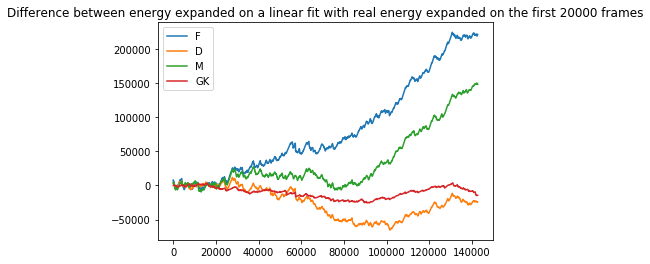

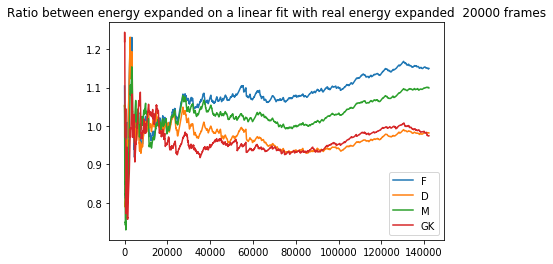

In [699]:
for pos, error in linear['error']:
    plt.plot(error, label=pos)
plt.title('Difference between energy expanded on a linear fit with real energy expanded on the first 20000 frames')
plt.legend()
plt.show()

for pos, error in linear['ratio']:
    plt.plot(error[500:], label=pos)
plt.title('Ratio between energy expanded on a linear fit with real energy expanded  20000 frames')
plt.legend()
plt.show()

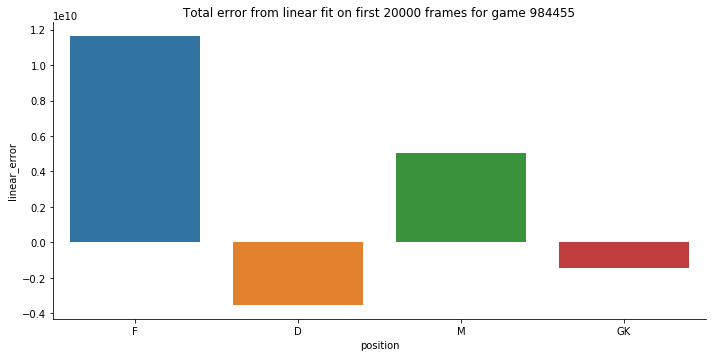

In [673]:
data_linear_error = pd.DataFrame([(pos, sum(errors)) for (pos, errors) in errors_linear], columns=['position', 'linear_error'])
sns.catplot(x='position', y='linear_error', data=data_linear_error, 
            kind='bar', height=5, aspect=2)
plt.title('Total error from linear fit on first 20000 frames for game {}'.format(match_id))
plt.show()

## 2nd degree free fit 

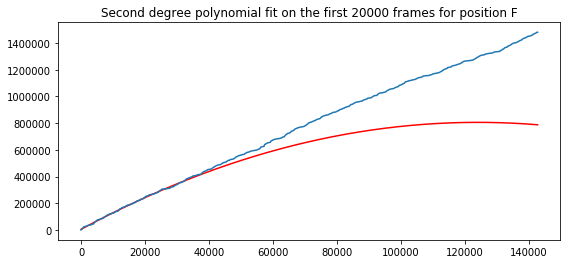

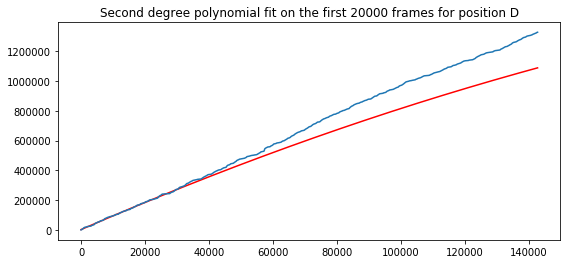

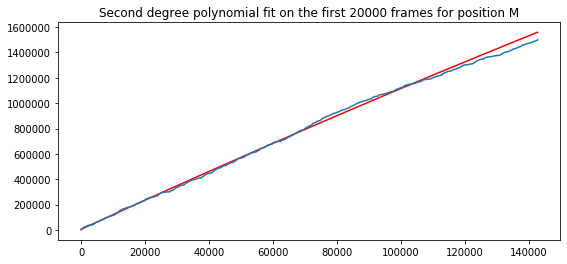

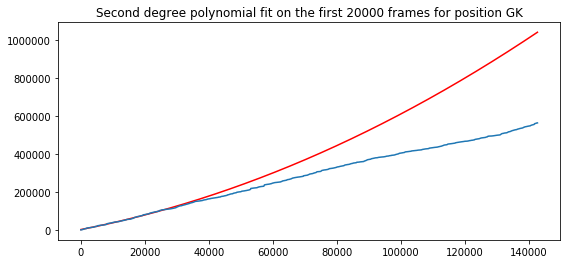

In [688]:
first_k = 20000
errors_2nd_deg = []

for pos, series in mean_E_per_pos:
    series_small = series[:first_k]
    xs_small, xs = np.array(range(len(series_small))), np.array(range(len(series)))
    a, b, c = np.polyfit(xs_small, series_small, 2)


    # error
    extended_2nd_degree = a*np.power(xs, 2) + b*xs + c
    error = extended_2nd_degree - series
    errors_2nd_deg.append((pos, a, error))

    # plot
    ax = plt.subplots(figsize=(9, 4))
    plt.plot(xs, extended_2nd_degree, 'r')
    plt.plot(series)
    plt.title('Second degree polynomial fit on the first {} frames for position {}'.format(first_k, pos))
    plt.show()

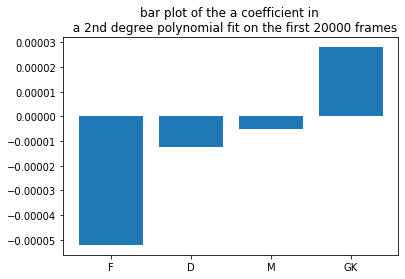

In [690]:
plt.bar(x=[x[0] for x in errors_2nd_deg], height=[x[1] for x in errors_2nd_deg])
plt.title('bar plot of the a coefficient in \n  a 2nd degree polynomial fit on the first {} frames'.format(first_k))
plt.show()

# Split by half time and analyze before after